### 1. Data imports

In [436]:
import pandas as pd
import pyreadr
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder

# use a pipeline in the end of the day
from sklearn.pipeline import Pipeline, FeatureUnion

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Model assement functionality
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

from scipy.stats import kstest, shapiro
from sklearn.metrics import matthews_corrcoef

%matplotlib inline

### 1. Configurations and loading data

In [ ]:
sns.set_theme(style="white")
result = pyreadr.read_r('./data/segm.RData')
df = result['segmentationOriginal'][['EqSphereAreaCh1', 'PerimCh1', 'Class', 'Case']]

df.columns = ['A', 'B', 'Class', 'Case']

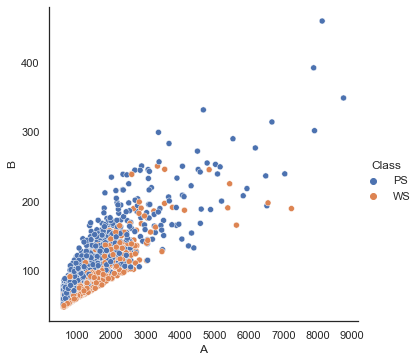

In [61]:
g = sns.relplot(x=df.A, y=df.B, hue=df.Class)

<AxesSubplot:xlabel='B', ylabel='Count'>

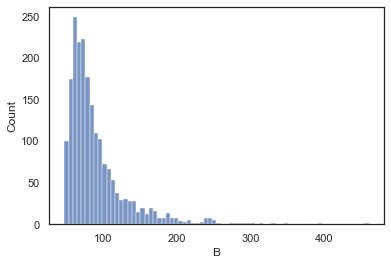

In [181]:
sns.histplot(df['B'])
# sns.histplot(df['A'])

<AxesSubplot:xlabel='B', ylabel='Density'>

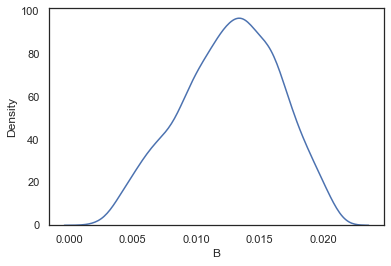

In [215]:
sns.kdeplot(1/df['B'])

#### We see a right skeweness which can be removed with a transformation

#### We use 1/x transformation to scatter points which are more concentrated near 0 to remove skeweness

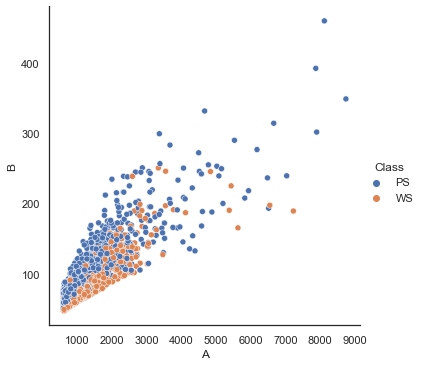

In [308]:
g = sns.relplot(x=df.A, y=df.B, hue=df.Class)

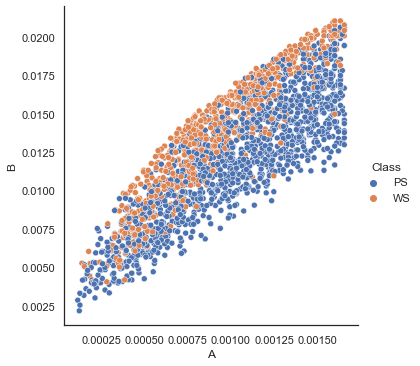

In [307]:
g = sns.relplot(x=1/df.A, y=1/df.B, hue=df.Class)

### Logistic Regression model

#### Logistic regression assumptions
* independence of errors, 
* linearity in the logit for continuous variables
* absence of multicollinearity
* lack of strongly influential outliers.


In [392]:
# apply logistic regression to a train set

X_train, X_test, y_train, y_test = train_test_split(df[['A', 'B']], df['Class'] == 'PS', test_size=0.5,
                                                   random_state=1)
lr = LogisticRegression(fit_intercept=True)
fit = lr.fit(X_train, y_train)
print('b0 =', fit.intercept_[0], ', beta1 =', fit.coef_[0][0], ', beta2 =', fit.coef_[0][1])
# this gives similiar although different estimates than the ones in the book

b0 = -1.5357108389283658 , beta1 = -0.003088369188868138 , beta2 = 0.07037288335706689


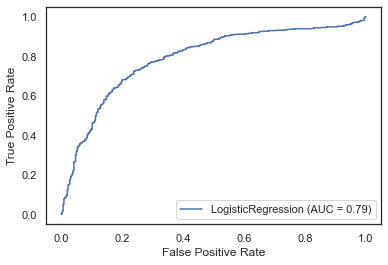

In [393]:
plot_roc_curve(lr, X_test, y_test);

#### Checking the assumptions of the logistic regression model

In [ ]:
# 1. independence of errors


In [410]:
# 2. no outliers
# 1/X seems to remove outliers and skeweness
# sns.boxplot(x=1/df['A'])
# sns.boxplot(x=1/df['B'])

In [411]:
# check the assumptions

# 3. linearity of the logit function
# Question: Is this how we check it?

# probabilities = lr.predict_proba(df[['A', 'B']])[:, 1]
# logit = np.log(probabilities / (1 - probabilities))
# sns.scatterplot(x=df['A'], y=logit, hue=df.Class)

# 4. absence of multicolinearity
# Question how to check that?

### The next model gives worse even though skeweness is removed

In [450]:
# apply logistic regression to a train set

# we apply the transformation 1/X, which removes skeweness, but the roc auc score is actually worse this time
reversed_features = 1/df[['A', 'B']]

X_train, X_test, y_train, y_test = train_test_split(reversed_features, df['Class'] == 'PS', test_size=0.5,
                                                   random_state=1)
lr = LogisticRegression(fit_intercept=True)
fit = lr.fit(X_train, y_train)
print('b0 =', fit.intercept_[0], ', beta1 =', fit.coef_[0][0], ', beta2 =', fit.coef_[0][1])
# this gives similiar although different estimates than the ones in the book

b0 = 0.6242465413972734 , beta1 = 0.024817065450005317 , beta2 = -0.36330737784068917


#### Plotting the ROC Curve and estimating the auc of the roc curve

We look for the up-left most point on the curve.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

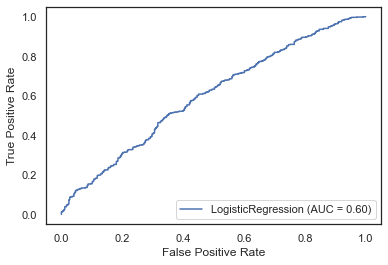

In [451]:
plot_roc_curve(lr, X_test, y_test);

### This worsens the model accuracy somehow

### kNN classification model

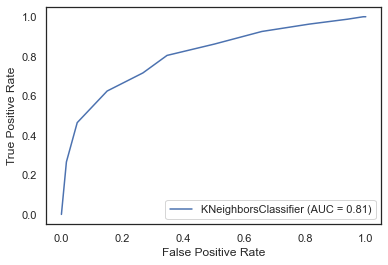

In [452]:
neighbours_clf = KNeighborsClassifier(n_neighbors=10)
neighbours_clf.fit(X_train, y_train)

plot_roc_curve(neighbours_clf, X_test, y_test);

### Neural Network model

In [212]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500)

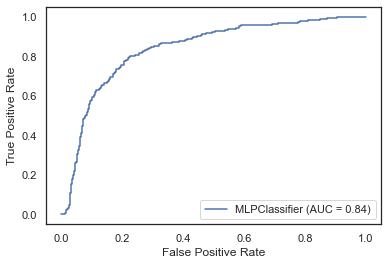

In [213]:
plot_roc_curve(mlp, X_test, y_test);

##### Seems to be giving a slightly better AUC score